# Music Churn:  Data Preparation / Feature Extraction Notebook
Python Notebook 1 of 3

## W207, Final Project
Spring, 2018

Team:  Cameron Kennedy, Gaurav Khanna, Aaron Olson


## Overview of Notebooks
For this project, the team created 3 separate Jupyter Notebooks to document its work:

**1) Data Preparation / Feature Extraction Notebook:**  This notebook gives an overview of the project, and then takes the raw data, performs some initial exploration, and generates features for the predictive models.  It also performs a brief exploratory data analysis on the feature set.  The output this notebook output a .pkl file of features for the second notebook to read, which saves considerable time when building the models.

**2) Predictive Modeling Notebook:**  This notebook reads the .pkl file, builds machine learning models to predict user churn, calculates and calibrates churn probabilities, and generates a projected economic impact of users who leave.

**3) Initial Data Sourcing and Validation Notebook:**  This is a static notebook (not intended for executing code) that documents two other aspects of the project that don't logically fit in either of the first two notebooks:

* First, it contains the initial data extraction code used in Google BigQuery to reduce the data set from ~30GB down to ~1.6GB, to enable it to run on local machines.

* Second, it contains some code that performs data integrity checks, validating that the items extracted in our smaller data set approximately match those in the full data set (e.g., same level of churn, the same timeframe, etc.)

## Table of Contents (this notebook only)

1. Project Overview
2. Data Set Overview
3. Initial Data Loading
4. User Logs Data: Preparation and Feature Extraction
5. Transaction Data: Preparation and Feature Extraction
6. Joining Features and Data Manipulation
7. Quick Exploratory Data Analysis
8. Writing Output

# 1. Project Overview
This dataset is comprised of data collected by WSDM regarding a music streaming subscription available through KKBOX.

## Project Goals:
The project aims to accomplish the following goals:

* Create a model to predict customer churn from usage and transaction data
* Create an economic model for retention
* Recommend a process for keeping the churn and economic retention models updated with latest information

# 2. Data Set Overview

The initial data set contains 24 variables (25 input variables and 1 variable to predict), these are spread across 4 tables.  Additional details:  

* **Original format:** csv
* **Total Size:** 31.14 GB, reduced to 1.6GB for analysis on local machines.
* ** User Count:** 1.02 million labeled users contained in the Train table (88,544 users after reduction)
* **Date Range:** The data of customer usage and trasactions with the service spans 26 months, from Jan. 2015 to Feb. 2017.  However, one of the data fields is initial date users joined the service, with dates ranging from 2004 to 2017.
* **Balance:** Approximately 6% of users in the data churned (positive labels); the remaining 94% stayed (negative labels).

Listed below are the tables and variables or features available for study:

## Table: Transactions
This table contains transaction data for each user. Each row is a payment transaction.

* **Data Shape:** 21.5M rows X 9 columns
* **Data Size:** 1.6GB

### Data Fields:

* **Msno:** User ID
* **Payment_method_id:** Payment Method
* **Payment_plan_days:** Length of plan
* **Plan_list_price:** Price for the plan
* **Actual_amount_paid:** Amount paid 
* **Is_auto_renew:** T/F flag determining whether membership is auto-renew or not
* **Transaction Date:** Date of purchase
* **Membership_expire_date:** Expiry date
* **Is_cancel:** T/F flag determining whether or not the user canceled service. This field is strongly correlated with the is_churn category, though it isn’t identical, as it also captures users who change service.

## Table: User Logs
This table lists who, how, and when users used the service.  Each row is a unique user-date combination.

* **Data Shape:** 392M rows X 9 columns
* **Data Size:** 29.1GB

### Data Fields:

* **Msno:** User ID
* **Date:** Date of the logged activity 
* **Num_25:** Number of songs played < 25% of song length
* **Num_50:** Number of songs played between 25% and 50%
* **Num_75:** Number of songs played between 50% and 75%
* **Num_985:** Number of songs played between 75% and 98.5%
* **Num_100:** Number of songs played between 98.5% and 100%
* **Num_unq:** Number of unique songs played
* **Total_secs:** Total seconds played

## Table: Members
Demographic data on each user.  Each row represents a unique user.

* **Data Shape:** 6.8M rows X 6 columns
* **Data Size:** 0.4GB

### Data Fields:

* **Msno:** User ID
* **City:** City of the user
* **BD:** Age of the user
* **Gender:** Male, Female or Blank
* **Registered_via:** Registration method
* **Registration_init_time:** Initial time of registration
* **Expiration_date:** Expiration of membership

## Table: Train
Labels of which users churned.  Each row represents a unique user.
* **Data Shape:** 1.0M rows X 2 columns
* **Data Size:** 45MB

### Data Fields:

* **Msno:** User ID
* **Is_churn:**  T/F flag variable we are trying to predict.

# 3. Initial Data Loading
This analysis is performed in the cells below.

In [1]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#Set initial parameter(s)
pd.set_option('display.max_rows', 200)
pd.options.display.max_columns = 2000

Loading the data indexing with the primary key (MSNO: String like/Object, represents the user)

In [2]:
#Load the data
members = pd.read_csv('members_filtered.csv')
transactions = pd.read_csv('transactions_filtered.csv')
user_logs = pd.read_csv('user_logs_filtered.csv')
labels = pd.read_csv('labels_filtered.csv')

#Set indices
members.set_index('msno', inplace = True)
labels.set_index('msno', inplace = True)

user_logs.head()

,msno,date,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs
0,MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=,20170217,37,2,2,3,30,66,9022.818
1,o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=,20160209,36,5,2,3,48,71,13895.453
2,6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=,20151210,26,9,3,0,51,54,13919.805
3,Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=,20161025,22,8,4,2,49,75,15147.842
4,zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=,20160904,26,3,1,0,39,60,10558.829


Performing a quick inspection of the data:

In [3]:
print('Transactions: \n')
transactions.info()

print('User Logs: \n')
user_logs.info()

print('Members: \n')
members.info()

print('User Logs:')
labels.info()

Transactions: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1353459 entries, 0 to 1353458
Data columns (total 9 columns):
msno                      1353459 non-null object
payment_method_id         1353459 non-null int64
payment_plan_days         1353459 non-null int64
plan_list_price           1353459 non-null int64
actual_amount_paid        1353459 non-null int64
is_auto_renew             1353459 non-null int64
transaction_date          1353459 non-null int64
membership_expire_date    1353459 non-null int64
is_cancel                 1353459 non-null int64
dtypes: int64(8), object(1)
memory usage: 92.9+ MB
User Logs: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19710631 entries, 0 to 19710630
Data columns (total 9 columns):
msno          object
date          int64
num_25        int64
num_50        int64
num_75        int64
num_985       int64
num_100       int64
num_unq       int64
total_secs    float64
dtypes: float64(1), int64(7), object(1)
memory usage: 1.3+ GB
Members

Helper routine to format the date for visualization:

In [4]:
def pd_to_date(df_col):
    """Function to convert a pandas dataframe column from %Y%m%d format to datetime format.
    
    Args:
        df_col (column in a pandas dataframe):  The column to be changed.
        
    Returns:
        The same column in datetime format.
        
    """
    df_col = pd.to_datetime(df_col, format = '%Y%m%d')
    return df_col

In [5]:
#Convert date column to date format
user_logs['date'] = pd_to_date(user_logs['date'])

The next two sections prepare the 2 major data tables/frames (User Logs & Transactions) independently and then bring them together for analysis.

# 4. User Logs Data:  Preparation and Feature Extraction

We first create our groupby object to ultimately aggregate data by users:

In [6]:
#Create our groupby user object 
user_logs_gb = user_logs.groupby(['msno'], sort=False)

The next cell creates three new columns:

* **max_date:**  The latest date each user has a transaction
* **days_before_max_date:**  The the number of days between the max date and the date of the current record.
* **listening_tenure:**  The the number of days between the max date and min date of the current user.  The hypothesis for this feature is that a user who's been using the service for a long time may be less likely to churn than one who's been using the service for a short time.

In [7]:
#This cell is slow

#Append max date to every row in main table
user_logs['max_date'] = user_logs_gb['date'].transform('max')
user_logs['days_before_max_date'] = (user_logs['max_date'] - user_logs['date']).apply(lambda x: x.days)
    #The .apply(lambda...  just converts it from datetime to an integer, for easier comparisons later.

#Generate user's first date, last date, and tenure
#Also, the user_logs_features table will be the primary table to return from the transactions table
user_logs_features = (user_logs_gb
    .agg({'date':['max', 'min', lambda x: (max(x) - min(x)).days]})  #.days converts to int
    .rename(columns={'max': 'max_date', 'min': 'min_date','<lambda>':'listening_tenure'})
                      )
#Add a 3rd level, used for joining data later
user_logs_features = pd.concat([user_logs_features], axis=1, keys=['date_features'])

Let's take a look at our initial users table:

In [8]:
user_logs_features.head()

date_features             \
                                                      date              
                                                  max_date   min_date   
msno                                                                    
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=    2017-02-27 2015-07-11   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=    2017-02-07 2015-03-10   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=    2017-02-17 2015-01-01   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=    2017-02-28 2016-09-08   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=    2017-02-13 2015-01-01   

                                                               
                                                               
                                             listening_tenure  
msno                                                           
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=              597  
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=              700  
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=              778  
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=              173  
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=              774

We now create features to look at patters of usage over the past X days, where X is days_before_max_date, to see what a user has been doing "lately".  We apply this rationale to all of the usage columns in the user_logs table, giving us combinations of the following elements of our data:

* Number of songs played < Y% of song length, where Y is 100, 985, 75, 50, and 25, plus the number of unique songs and total seconds played.
* Activity over the last day, last 7, 30, 90, 180, 365, and total days, noting that the date range is relative to user's most recent activity.

For each of these combinations, we calulate (using groupby and aggregate) both the sum and mean of each feature.  And finally we also create a single, total count column (number of rows) for the past number of days.  In total, this generates 120 features, which we then append to the user_logs_features table above.

In [9]:
#Create Features:
    # Total X=(seconds, 100, 985, 75, 50, 25, unique), avg per day of X, maybe median per day of X
    # Last day, last 7 days, last 30 days, last 90, 180, 365, total (note last day is relative to user)
    
for num_days in [1, 7, 14, 31, 90, 180, 365, 9999]:
    #Create groupby object for items with x days
    ul_gb_xdays = (user_logs.loc[(user_logs['days_before_max_date'] < num_days)]
                   .groupby(['msno'], sort=False))

    #Generate sum and mean (and count, once) for all the user logs stats
    past_xdays_by_user = (ul_gb_xdays
        .agg({'num_unq':['sum', 'mean', 'count'],
              'total_secs':['sum', 'mean'],
              'num_25':['sum', 'mean'],
              'num_50':['sum', 'mean'],
              'num_75':['sum', 'mean'],
              'num_985':['sum', 'mean'],
              'num_100':['sum', 'mean'],
             })
                      )
    #Append level header
    past_xdays_by_user = pd.concat([past_xdays_by_user], axis=1, keys=['within_days_' + str(num_days)])

    #Join (append) to user_logs_features table
    user_logs_features = user_logs_features.join(past_xdays_by_user, how='inner')

Taking a quick look at our table now:

In [10]:
user_logs_features.head()

date_features             \
                                                      date              
                                                  max_date   min_date   
msno                                                                    
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=    2017-02-27 2015-07-11   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=    2017-02-07 2015-03-10   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=    2017-02-17 2015-01-01   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=    2017-02-28 2016-09-08   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=    2017-02-13 2015-01-01   

                                                              within_days_1  \
                                                                    num_unq   
                                             listening_tenure           sum   
msno                                                                          
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=              597            17   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=              700             1   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=              778            13   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=              173            86   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=              774            22   

                                                                               \
                                                        total_secs              
                                             mean count        sum       mean   
msno                                                                            
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=   17     1  29802.123  29802.123   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=    1     1    274.176    274.176   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=   13     1  10363.972  10363.972   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=   86     1  21094.770  21094.770   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=   22     1   2803.117   2803.117   

                                                                             \
                                             num_25      num_50      num_75   
                                                sum mean    sum mean    sum   
msno                                                                          
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=     17   17      1    1      0   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=      0    0      0    0      0   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=      5    5      1    1      1   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=     10   10      6    6      7   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=      9    9      0    0      3   

                                                                             \
                                                  num_985      num_100        
                                             mean     sum mean     sum mean   
msno                                                                          
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=    0       1    1     115  115   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=    0       0    0       1    1   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=    1       4    4      41   41   
Xt9VAHNtHuST21tkcZSnGKjwv8vF8/COnsf6z28+fKk=    7       4    4      72   72   
zSgTJqoosTiFF7ZZi1DPTHgxLbnd99IgOEsTIDCcZHc=    3       0    0      10   10   

                                             within_days_7                   \
                                                   num_unq                    
                                                       sum       mean count   
msno                                                                          
MVODUEUlSocm1sXa+zVGpJazPrRFiD4IzEQk0QCdg4U=           161  26.833333     6   
o3Dg7baW8dXq7Jq7NzlVrWG4mZNVvqp62oWBDO/ybeE=           161  26.833333     6   
6ERcO7aqAKvrQ2CAvah79dVC7tJVZSjNti1MBfpNVW4=   

Good, we get the expected number of columns.

# 5. Transaction Data: Preparation and Feature Extraction
Having completed feature extraction for user logs, we now move on to creating features for the transaction data.

We begin grouping the data by user.

In [11]:
# Grouping by the member (msno)
transactions_gb = transactions.sort_values(["transaction_date"]).groupby(['msno'])

# How many groups i.e. members i.e. msno's. We're good if this is the same number as the members table
print('%d Groups/msnos' %(len(transactions_gb.groups)))
print('%d Features' %(len(transactions.columns)))

99825 Groups/msnos
9 Features


We plan to create the following features from the transactions table:
* Simple featuers from the latest transaction
    * Plan no of days
    * plan total amount paid
    * plan list price
    * Is_auto_renew
    * is_cancel
* Synthetic features from the latest transaction
    * Plan actual amount paid/day 
* Aggregate values
    * Total number of plan days
    * Total of all the amounts paid for the plan
* Comparing transactions
    * Plan day difference among the latest and previous transaction
    * Amount paid/day difference among the latest and previous transaction

We begin by creating the total_plan_days and total_amount_paid:

In [12]:
# Features: Total_plan_days, Total_amount_paid
transactions_features = (transactions_gb
    .agg({'payment_plan_days':'sum', 'actual_amount_paid':'sum' })
    .rename(columns={'payment_plan_days': 'total_plan_days', 'actual_amount_paid': 'total_amount_paid',})
          )
print('%d Entries in the DF: ' %(len(transactions_features)))
print('%d Features' %(len(transactions_features.columns)))

transactions_features.head()

99825 Entries in the DF: 
2 Features


,total_plan_days,total_amount_paid
msno,,
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,543,2831
++5nv+2nsvrWM7dOT+ZiWJ5uTZOzQS0NEvqu3jidTjU=,90,297
++7IULiyKbNc8jllqhRuyKZjX1J4mPF4tsudFCJfv4k=,513,2682
++Ck01c3EF07Ejek2jfXlKut+sEfg+0ry+A5uWeL9vY=,270,891
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=,457,2235


Next, we add amount_paid_per_day for a user's entire tenure:

In [13]:
# Plan actual amount paid/day for all the transactions by a user
# Adding the collumn amount_paid_per_day
transactions_features['amount_paid_per_day'] = (transactions_features['total_amount_paid']
                                                /transactions_features['total_plan_days'])

print('%d Entries in the DF: ' %(len(transactions_features)))
print('%d Features' %(len(transactions_features.columns)))

transactions_features.head()

99825 Entries in the DF: 
3 Features


,total_plan_days,total_amount_paid,amount_paid_per_day
msno,,,
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,543,2831,5.213628
++5nv+2nsvrWM7dOT+ZiWJ5uTZOzQS0NEvqu3jidTjU=,90,297,3.300000
++7IULiyKbNc8jllqhRuyKZjX1J4mPF4tsudFCJfv4k=,513,2682,5.228070
++Ck01c3EF07Ejek2jfXlKut+sEfg+0ry+A5uWeL9vY=,270,891,3.300000
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=,457,2235,4.890591


Next, we add latest_payment_method_id, latest_plan_days, latest_plan_list_price, latest_amount_paid, latest_auto_renew, latest_transaction_date, latest_expire_date, and latest_is_cancel.  We accomplish this by picking from the bottom of the ordered (by date) rows in groups.

In [14]:
# Features: latest transaction, renaming the collumns
# V1- Fixed the name for plan_list_price collumn (now called latest_plan_list_price)

latest_transaction= transactions_gb.tail([1]).rename(columns={'payment_method_id': 'latest_payment_method_id',
                                                                  'payment_plan_days': 'latest_plan_days',
                                                                  'plan_list_price': 'latest_plan_list_price',
                                                                  'actual_amount_paid': 'latest_amount_paid',
                                                                  'is_auto_renew': 'latest_auto_renew', 
                                                                  'transaction_date': 'latest_transaction_date',
                                                                  'membership_expire_date': 'latest_expire_date',
                                                                  'is_cancel': 'latest_is_cancel' })

# Index by msno
latest_transaction.set_index('msno', inplace = True)

print('%d Entries in the DF: ' %(len(latest_transaction)))
print('%d Features' %(len(latest_transaction.columns)))

latest_transaction.head()

99825 Entries in the DF: 
8 Features


,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel
msno,,,,,,,,
z1Lm/BlRQraiaWJ7RaQWe0+l0Z40ACj7W+zk29FiaS4=,38,30,149,149,0,20150102,20150503,0
IwE/pih8PuqrY/rsnoZ/4TazDliyH9S8VWNc2/d7mJg=,38,30,149,149,0,20150102,20150702,0
ea9rY0uEPY0ImD2QVbYFb+z3zi5wniKWMUM1V8os7OY=,32,410,1788,1788,0,20150104,20170213,0
plhzwjmNJp0HW04NidfVa35JE216RaFYpSeUCwT11zQ=,38,30,149,149,0,20150120,20170103,0
PbSQ2KxR4gRnzjsRd8Up75qMYb70iuMwGk10/jPRljk=,38,360,1200,1200,0,20150123,20170212,0


Next, we add latest_amount_paid_per_day:

In [15]:
# Plan actual amount paid/day for the latest transaction
# Adding the collumn amount_paid_per_day

latest_transaction['latest_amount_paid_per_day'] = (latest_transaction['latest_amount_paid']
                                                /latest_transaction['latest_plan_days'])

print('%d Entries in the DF: ' %(len(latest_transaction)))
print('%d Features' %(len(latest_transaction.columns)))

latest_transaction.head()

99825 Entries in the DF: 
9 Features


,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel,latest_amount_paid_per_day
msno,,,,,,,,,
z1Lm/BlRQraiaWJ7RaQWe0+l0Z40ACj7W+zk29FiaS4=,38,30,149,149,0,20150102,20150503,0,4.966667
IwE/pih8PuqrY/rsnoZ/4TazDliyH9S8VWNc2/d7mJg=,38,30,149,149,0,20150102,20150702,0,4.966667
ea9rY0uEPY0ImD2QVbYFb+z3zi5wniKWMUM1V8os7OY=,32,410,1788,1788,0,20150104,20170213,0,4.360976
plhzwjmNJp0HW04NidfVa35JE216RaFYpSeUCwT11zQ=,38,30,149,149,0,20150120,20170103,0,4.966667
PbSQ2KxR4gRnzjsRd8Up75qMYb70iuMwGk10/jPRljk=,38,360,1200,1200,0,20150123,20170212,0,3.333333


Next, we compare two different items in our transaction data:

* Plan duration difference among the last 2 transactons
* Cost difference among the last 2 transactions

In [16]:
# Getting the 2 latest transactions and grouping by msno again
latest_transaction2_gb = transactions_gb.tail([2]).groupby(['msno'])

# Getting the latest but one transaction
latest2_transaction = latest_transaction2_gb.head([1])

# Index by msno
latest2_transaction.set_index('msno', inplace = True)

# Amount paid per day for the 2nd latest transaction
latest2_transaction['latest2_amount_paid_per_day'] = (latest2_transaction['actual_amount_paid']
                                                /latest2_transaction['payment_plan_days'])

# Difference in the renewal length among the latest 2 transactions
transactions_features['diff_renewal_duration'] = (latest_transaction['latest_plan_days']
                                                - latest2_transaction['payment_plan_days'])

# Different in plan cost among the latest 2 transactions
transactions_features['diff_plan_amount_paid_per_day'] = (latest_transaction['latest_amount_paid_per_day'] 
                                                          - latest2_transaction['latest2_amount_paid_per_day'])

print('%d Entries in the DF: ' %(len(transactions_features)))
print('%d Features' %(len(transactions_features.columns)))

transactions_features.head()

C:\Users\camke\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


99825 Entries in the DF: 
5 Features


,total_plan_days,total_amount_paid,amount_paid_per_day,diff_renewal_duration,diff_plan_amount_paid_per_day
msno,,,,,
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,543,2831,5.213628,0,0.000000
++5nv+2nsvrWM7dOT+ZiWJ5uTZOzQS0NEvqu3jidTjU=,90,297,3.300000,0,0.000000
++7IULiyKbNc8jllqhRuyKZjX1J4mPF4tsudFCJfv4k=,513,2682,5.228070,0,0.000000
++Ck01c3EF07Ejek2jfXlKut+sEfg+0ry+A5uWeL9vY=,270,891,3.300000,0,0.000000
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=,457,2235,4.890591,23,4.966667


Finally, we join all the features into a single data frame:

In [17]:
# Get all transaction features in a single DF
transactions_features = transactions_features.join(latest_transaction, how = 'inner')

# Test
print('%d Entries in the DF: ' %(len(transactions_features)))
print('%d Features' %(len(transactions_features.columns)))

transactions_features.head()

99825 Entries in the DF: 
14 Features


,total_plan_days,total_amount_paid,amount_paid_per_day,diff_renewal_duration,diff_plan_amount_paid_per_day,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel,latest_amount_paid_per_day
msno,,,,,,,,,,,,,,
+++l/EXNMLTijfLBa8p2TUVVVp2aFGSuUI/h7mLmthw=,543,2831,5.213628,0,0.000000,39,30,149,149,1,20170131,20170319,0,4.966667
++5nv+2nsvrWM7dOT+ZiWJ5uTZOzQS0NEvqu3jidTjU=,90,297,3.300000,0,0.000000,41,30,99,99,1,20170201,20170301,0,3.300000
++7IULiyKbNc8jllqhRuyKZjX1J4mPF4tsudFCJfv4k=,513,2682,5.228070,0,0.000000,37,30,149,149,1,20170201,20170301,0,4.966667
++Ck01c3EF07Ejek2jfXlKut+sEfg+0ry+A5uWeL9vY=,270,891,3.300000,0,0.000000,41,30,99,99,1,20170214,20170314,0,3.300000
++FPL1dXZBXC3Cf6gE0HQiIHg1Pd+DBdK7w52xcUmX0=,457,2235,4.890591,23,4.966667,41,30,149,149,1,20160225,20160225,1,4.966667


# 6. Joining Features and Data Manipulation

## Joining Features

Having completed features by user from the User Logs and Transactions tables, we will now join the features from these tables together with the Members and Labels (a.k.a., train) tables into a single data frame for predictive modeling.

First, we'll join the Members and Labels together:

In [18]:
#Join members and labels files
df_fa = None
df_fa = members.join(labels, how='inner')

df_fa.head()

,city,bd,gender,registered_via,registration_init_time,is_churn
msno,,,,,,
mKfgXQAmVeSKzN4rXW37qz0HbGCuYBspTBM3ONXZudg=,1,0,NaN,13,20170120,0
AFcKYsrudzim8OFa+fL/c9g5gZabAbhaJnoM0qmlJfo=,1,0,NaN,13,20160907,0
qk4mEZUYZq+4sQE7bzRYKc5Pvj+Xc7Wmu25DrCzltEU=,1,0,NaN,13,20160902,0
G2UGNLph2J6euGmZ7WIa1+Kc+dPZBJI0HbLPu5YtrZw=,1,0,NaN,13,20161028,0
EqSHZpMj5uddJvv2gXcHvuOKFOdS5NN6RalHfzEhhaI=,1,0,NaN,13,20161004,0


Next, we join the User Logs features table with the combined Members and the Labels table:

In [19]:
df_fa = df_fa.join(user_logs_features, how='inner')
#Note, the warning is okay, and actually helps us by flattening our column headers.

df_fa.head()

C:\Users\camke\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 3 on the right)
  warnings.warn(msg, UserWarning)


,city,bd,gender,registered_via,registration_init_time,is_churn,"(date_features, date, max_date)","(date_features, date, min_date)","(date_features, date, listening_tenure)","(within_days_1, num_unq, sum)","(within_days_1, num_unq, mean)","(within_days_1, num_unq, count)","(within_days_1, total_secs, sum)","(within_days_1, total_secs, mean)","(within_days_1, num_25, sum)","(within_days_1, num_25, mean)","(within_days_1, num_50, sum)","(within_days_1, num_50, mean)","(within_days_1, num_75, sum)","(within_days_1, num_75, mean)","(within_days_1, num_985, sum)","(within_days_1, num_985, mean)","(within_days_1, num_100, sum)","(within_days_1, num_100, mean)","(within_days_7, num_unq, sum)","(within_days_7, num_unq, mean)","(within_days_7, num_unq, count)","(within_days_7, total_secs, sum)","(within_days_7, total_secs, mean)","(within_days_7, num_25, sum)","(within_days_7, num_25, mean)","(within_days_7, num_50, sum)","(within_days_7, num_50, mean)","(within_days_7, num_75, sum)","(within_days_7, num_75, mean)","(within_days_7, num_985, sum)","(within_days_7, num_985, mean)","(within_days_7, num_100, sum)","(within_days_7, num_100, mean)","(within_days_14, num_unq, sum)","(within_days_14, num_unq, mean)","(within_days_14, num_unq, count)","(within_days_14, total_secs, sum)","(within_days_14, total_secs, mean)","(within_days_14, num_25, sum)","(within_days_14, num_25, mean)","(within_days_14, num_50, sum)","(within_days_14, num_50, mean)","(within_days_14, num_75, sum)","(within_days_14, num_75, mean)","(within_days_14, num_985, sum)","(within_days_14, num_985, mean)","(within_days_14, num_100, sum)","(within_days_14, num_100, mean)","(within_days_31, num_unq, sum)","(within_days_31, num_unq, mean)","(within_days_31, num_unq, count)","(within_days_31, total_secs, sum)","(within_days_31, total_secs, mean)","(within_days_31, num_25, sum)","(within_days_31, num_25, mean)","(within_days_31, num_50, sum)","(within_days_31, num_50, mean)","(within_days_31, num_75, sum)","(within_days_31, num_75, mean)","(within_days_31, num_985, sum)","(within_days_31, num_985, mean)","(within_days_31, num_100, sum)","(within_days_31, num_100, mean)","(within_days_90, num_unq, sum)","(within_days_90, num_unq, mean)","(within_days_90, num_unq, count)","(within_days_90, total_secs, sum)","(within_days_90, total_secs, mean)","(within_days_90, num_25, sum)","(within_days_90, num_25, mean)","(within_days_90, num_50, sum)","(within_days_90, num_50, mean)","(within_days_90, num_75, sum)","(within_days_90, num_75, mean)","(within_days_90, num_985, sum)","(within_days_90, num_985, mean)","(within_days_90, num_100, sum)","(within_days_90, num_100, mean)","(within_days_180, num_unq, sum)","(within_days_180, num_unq, mean)","(within_days_180, num_unq, count)","(within_days_180, total_secs, sum)","(within_days_180, total_secs, mean)","(within_days_180, num_25, sum)","(within_days_180, num_25, mean)","(within_days_180, num_50, sum)","(within_days_180, num_50, mean)","(within_days_180, num_75, sum)","(within_days_180, num_75, mean)","(within_days_180, num_985, sum)","(within_days_180, num_985, mean)","(within_days_180, num_100, sum)","(within_days_180, num_100, mean)","(within_days_365, num_unq, sum)","(within_days_365, num_unq, mean)","(within_days_365, num_unq, count)","(within_days_365, total_secs, sum)","(within_days_365, total_secs, mean)","(within_days_365, num_25, sum)","(within_days_365, num_25, mean)","(within_days_365, num_50, sum)","(within_days_365, num_50, mean)","(within_days_365, num_75, sum)","(within_days_365, num_75, mean)","(within_days_365, num_985, sum)","(within_days_365, num_985, mean)","(within_days_365, num_100, sum)","(within_days_365, num_100, mean)","(within_days_9999, num_unq, sum)","(within_days_9999, num_unq, mean)","(within_days_9999, num_unq, count)","(within_days_9999, total_secs, sum)","(within_days_9999, total_secs, mean)","(within_days_9999, num_25, sum)","(within_days_9999, num_25, mean)","(within_days_9999, num_50, sum)","(within_da

Finally, we'll join in our Transaction features:

In [20]:
# Joining feature DF's
df_fa = df_fa.join(transactions_features, how='inner')

print('%d Entries in the DF: ' %(len(df_fa)))
print('%d Features' %(len(df_fa.columns)))
df_fa.head()

88544 Entries in the DF: 
143 Features


,city,bd,gender,registered_via,registration_init_time,is_churn,"(date_features, date, max_date)","(date_features, date, min_date)","(date_features, date, listening_tenure)","(within_days_1, num_unq, sum)","(within_days_1, num_unq, mean)","(within_days_1, num_unq, count)","(within_days_1, total_secs, sum)","(within_days_1, total_secs, mean)","(within_days_1, num_25, sum)","(within_days_1, num_25, mean)","(within_days_1, num_50, sum)","(within_days_1, num_50, mean)","(within_days_1, num_75, sum)","(within_days_1, num_75, mean)","(within_days_1, num_985, sum)","(within_days_1, num_985, mean)","(within_days_1, num_100, sum)","(within_days_1, num_100, mean)","(within_days_7, num_unq, sum)","(within_days_7, num_unq, mean)","(within_days_7, num_unq, count)","(within_days_7, total_secs, sum)","(within_days_7, total_secs, mean)","(within_days_7, num_25, sum)","(within_days_7, num_25, mean)","(within_days_7, num_50, sum)","(within_days_7, num_50, mean)","(within_days_7, num_75, sum)","(within_days_7, num_75, mean)","(within_days_7, num_985, sum)","(within_days_7, num_985, mean)","(within_days_7, num_100, sum)","(within_days_7, num_100, mean)","(within_days_14, num_unq, sum)","(within_days_14, num_unq, mean)","(within_days_14, num_unq, count)","(within_days_14, total_secs, sum)","(within_days_14, total_secs, mean)","(within_days_14, num_25, sum)","(within_days_14, num_25, mean)","(within_days_14, num_50, sum)","(within_days_14, num_50, mean)","(within_days_14, num_75, sum)","(within_days_14, num_75, mean)","(within_days_14, num_985, sum)","(within_days_14, num_985, mean)","(within_days_14, num_100, sum)","(within_days_14, num_100, mean)","(within_days_31, num_unq, sum)","(within_days_31, num_unq, mean)","(within_days_31, num_unq, count)","(within_days_31, total_secs, sum)","(within_days_31, total_secs, mean)","(within_days_31, num_25, sum)","(within_days_31, num_25, mean)","(within_days_31, num_50, sum)","(within_days_31, num_50, mean)","(within_days_31, num_75, sum)","(within_days_31, num_75, mean)","(within_days_31, num_985, sum)","(within_days_31, num_985, mean)","(within_days_31, num_100, sum)","(within_days_31, num_100, mean)","(within_days_90, num_unq, sum)","(within_days_90, num_unq, mean)","(within_days_90, num_unq, count)","(within_days_90, total_secs, sum)","(within_days_90, total_secs, mean)","(within_days_90, num_25, sum)","(within_days_90, num_25, mean)","(within_days_90, num_50, sum)","(within_days_90, num_50, mean)","(within_days_90, num_75, sum)","(within_days_90, num_75, mean)","(within_days_90, num_985, sum)","(within_days_90, num_985, mean)","(within_days_90, num_100, sum)","(within_days_90, num_100, mean)","(within_days_180, num_unq, sum)","(within_days_180, num_unq, mean)","(within_days_180, num_unq, count)","(within_days_180, total_secs, sum)","(within_days_180, total_secs, mean)","(within_days_180, num_25, sum)","(within_days_180, num_25, mean)","(within_days_180, num_50, sum)","(within_days_180, num_50, mean)","(within_days_180, num_75, sum)","(within_days_180, num_75, mean)","(within_days_180, num_985, sum)","(within_days_180, num_985, mean)","(within_days_180, num_100, sum)","(within_days_180, num_100, mean)","(within_days_365, num_unq, sum)","(within_days_365, num_unq, mean)","(within_days_365, num_unq, count)","(within_days_365, total_secs, sum)","(within_days_365, total_secs, mean)","(within_days_365, num_25, sum)","(within_days_365, num_25, mean)","(within_days_365, num_50, sum)","(within_days_365, num_50, mean)","(within_days_365, num_75, sum)","(within_days_365, num_75, mean)","(within_days_365, num_985, sum)","(within_days_365, num_985, mean)","(within_days_365, num_100, sum)","(within_days_365, num_100, mean)","(within_days_9999, num_unq, sum)","(within_days_9999, num_unq, mean)","(within_days_9999, num_unq, count)","(within_days_9999, total_secs, sum)","(within_days_9999, total_secs, mean)","(within_days_9999, num_25, sum)","(within_days_9999, num_25, mean)","(within_days_9999, num_50, sum)","(within_da

##  Data Manipulation
Having joined all the features into a single file, we will now perform some data manipulation tasks to prepare the table for predictive modeling.

First, we will fix the column headers:

In [21]:
#Fix column headers
df_fa.columns = df_fa.columns.map(''.join)
df_fa.head()

,city,bd,gender,registered_via,registration_init_time,is_churn,date_featuresdatemax_date,date_featuresdatemin_date,date_featuresdatelistening_tenure,within_days_1num_unqsum,within_days_1num_unqmean,within_days_1num_unqcount,within_days_1total_secssum,within_days_1total_secsmean,within_days_1num_25sum,within_days_1num_25mean,within_days_1num_50sum,within_days_1num_50mean,within_days_1num_75sum,within_days_1num_75mean,within_days_1num_985sum,within_days_1num_985mean,within_days_1num_100sum,within_days_1num_100mean,within_days_7num_unqsum,within_days_7num_unqmean,within_days_7num_unqcount,within_days_7total_secssum,within_days_7total_secsmean,within_days_7num_25sum,within_days_7num_25mean,within_days_7num_50sum,within_days_7num_50mean,within_days_7num_75sum,within_days_7num_75mean,within_days_7num_985sum,within_days_7num_985mean,within_days_7num_100sum,within_days_7num_100mean,within_days_14num_unqsum,within_days_14num_unqmean,within_days_14num_unqcount,within_days_14total_secssum,within_days_14total_secsmean,within_days_14num_25sum,within_days_14num_25mean,within_days_14num_50sum,within_days_14num_50mean,within_days_14num_75sum,within_days_14num_75mean,within_days_14num_985sum,within_days_14num_985mean,within_days_14num_100sum,within_days_14num_100mean,within_days_31num_unqsum,within_days_31num_unqmean,within_days_31num_unqcount,within_days_31total_secssum,within_days_31total_secsmean,within_days_31num_25sum,within_days_31num_25mean,within_days_31num_50sum,within_days_31num_50mean,within_days_31num_75sum,within_days_31num_75mean,within_days_31num_985sum,within_days_31num_985mean,within_days_31num_100sum,within_days_31num_100mean,within_days_90num_unqsum,within_days_90num_unqmean,within_days_90num_unqcount,within_days_90total_secssum,within_days_90total_secsmean,within_days_90num_25sum,within_days_90num_25mean,within_days_90num_50sum,within_days_90num_50mean,within_days_90num_75sum,within_days_90num_75mean,within_days_90num_985sum,within_days_90num_985mean,within_days_90num_100sum,within_days_90num_100mean,within_days_180num_unqsum,within_days_180num_unqmean,within_days_180num_unqcount,within_days_180total_secssum,within_days_180total_secsmean,within_days_180num_25sum,within_days_180num_25mean,within_days_180num_50sum,within_days_180num_50mean,within_days_180num_75sum,within_days_180num_75mean,within_days_180num_985sum,within_days_180num_985mean,within_days_180num_100sum,within_days_180num_100mean,within_days_365num_unqsum,within_days_365num_unqmean,within_days_365num_unqcount,within_days_365total_secssum,within_days_365total_secsmean,within_days_365num_25sum,within_days_365num_25mean,within_days_365num_50sum,within_days_365num_50mean,within_days_365num_75sum,within_days_365num_75mean,within_days_365num_985sum,within_days_365num_985mean,within_days_365num_100sum,within_days_365num_100mean,within_days_9999num_unqsum,within_days_9999num_unqmean,within_days_9999num_unqcount,within_days_9999total_secssum,within_days_9999total_secsmean,within_days_9999num_25sum,within_days_9999num_25mean,within_days_9999num_50sum,within_days_9999num_50mean,within_days_9999num_75sum,within_days_9999num_75mean,within_days_9999num_985sum,within_days_9999num_985mean,within_days_9999num_100sum,within_days_9999num_100mean,total_plan_days,total_amount_paid,amount_paid_per_day,diff_renewal_duration,diff_plan_amount_paid_per_day,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel,latest_amount_paid_per_day
msno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mKfgXQAmVeSKzN4rXW37qz0HbGCuYBspTBM3ONXZudg=,1,0,NaN,13,20170120,0,2017-02-24,2017-01-20,35,1,1,1,10.068,10.068,2,2,0,0,0,0,0,0,0,0,1,1.000000,1,10.068,10.068000,2,2.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,1,1.000000,1,10.068,10.068000,2,2.000000,0,0.000000,0,0.000000,0,0.000000,0,0.000000,27,6

Next, we will change infinite and 'na' values to -9999, wildly different than other values in the range, so that our algorithms see them as 'different'.

In [22]:
#Handle bad values
df_fa['amount_paid_per_day'].replace([np.inf, -np.inf], -9999, inplace=True)
df_fa['latest_amount_paid_per_day'].replace([np.inf, -np.inf], -9999, inplace=True)
df_fa['diff_plan_amount_paid_per_day'].replace([np.inf, -np.inf], -9999, inplace=True)
df_fa['diff_plan_amount_paid_per_day'].fillna(-9999, inplace=True)
df_fa.isnull().any()

city                                 False
bd                                   False
gender                                True
registered_via                       False
registration_init_time               False
is_churn                             False
date_featuresdatemax_date            False
date_featuresdatemin_date            False
date_featuresdatelistening_tenure    False
within_days_1num_unqsum              False
within_days_1num_unqmean             False
within_days_1num_unqcount            False
within_days_1total_secssum           False
within_days_1total_secsmean          False
within_days_1num_25sum               False
within_days_1num_25mean              False
within_days_1num_50sum               False
within_days_1num_50mean              False
within_days_1num_75sum               False
within_days_1num_75mean              False
within_days_1num_985sum              False
within_days_1num_985mean             False
within_days_1num_100sum              False
within_days

The cell above uploads verifies we have no null values in our data.

Now let's inspect our data types:

In [23]:
df_fa.dtypes

city                                          int64
bd                                            int64
gender                                       object
registered_via                                int64
registration_init_time                        int64
is_churn                                      int64
date_featuresdatemax_date            datetime64[ns]
date_featuresdatemin_date            datetime64[ns]
date_featuresdatelistening_tenure             int64
within_days_1num_unqsum                       int64
within_days_1num_unqmean                      int64
within_days_1num_unqcount                     int64
within_days_1total_secssum                  float64
within_days_1total_secsmean                 float64
within_days_1num_25sum                        int64
within_days_1num_25mean                       int64
within_days_1num_50sum                        int64
within_days_1num_50mean                       int64
within_days_1num_75sum                        int64
within_days_

We see we have a couple datetime objects in the file.  We'll need to address these, as the ML algorithms don't like them.  The code below breaks datetime formatted columns up into 4 separate columns.

In [24]:
def split_date_col(date_col_name):
    """Function that takes a column of datetime64[ns] items and converts it into 4 columns:
        1) Year integer
        2) Month integer
        3) Day integer
        4) Days since January 1, 2001, as an integer
        
        It then deletes the original date 
        
    Args:
        date_col_name (string):  The column name, as a string.
    """
    df_fa[date_col_name + '_year'] = df_fa[date_col_name].dt.year
    df_fa[date_col_name + '_month'] = df_fa[date_col_name].dt.month
    df_fa[date_col_name + '_day'] = df_fa[date_col_name].dt.day
    df_fa[date_col_name + '_absday'] = ((df_fa[date_col_name] - pd.to_datetime('1/1/2000'))
                                      .astype('timedelta64[D]')
                                      .astype('int64')
                                     )
    df_fa.drop(date_col_name, axis=1, inplace=True)

In [25]:
#Only run this cell once, else it will fail on the date columns it deletes
split_date_col('date_featuresdatemax_date')
split_date_col('date_featuresdatemin_date')

Now let's re-check our cells:

In [26]:
df_fa.dtypes

city                                   int64
bd                                     int64
gender                                object
registered_via                         int64
registration_init_time                 int64
is_churn                               int64
date_featuresdatelistening_tenure      int64
within_days_1num_unqsum                int64
within_days_1num_unqmean               int64
within_days_1num_unqcount              int64
within_days_1total_secssum           float64
within_days_1total_secsmean          float64
within_days_1num_25sum                 int64
within_days_1num_25mean                int64
within_days_1num_50sum                 int64
within_days_1num_50mean                int64
within_days_1num_75sum                 int64
within_days_1num_75mean                int64
within_days_1num_985sum                int64
within_days_1num_985mean               int64
within_days_1num_100sum                int64
within_days_1num_100mean               int64
within_day

In [27]:
df_fa.describe(include='all')

,city,bd,gender,registered_via,registration_init_time,is_churn,date_featuresdatelistening_tenure,within_days_1num_unqsum,within_days_1num_unqmean,within_days_1num_unqcount,within_days_1total_secssum,within_days_1total_secsmean,within_days_1num_25sum,within_days_1num_25mean,within_days_1num_50sum,within_days_1num_50mean,within_days_1num_75sum,within_days_1num_75mean,within_days_1num_985sum,within_days_1num_985mean,within_days_1num_100sum,within_days_1num_100mean,within_days_7num_unqsum,within_days_7num_unqmean,within_days_7num_unqcount,within_days_7total_secssum,within_days_7total_secsmean,within_days_7num_25sum,within_days_7num_25mean,within_days_7num_50sum,within_days_7num_50mean,within_days_7num_75sum,within_days_7num_75mean,within_days_7num_985sum,within_days_7num_985mean,within_days_7num_100sum,within_days_7num_100mean,within_days_14num_unqsum,within_days_14num_unqmean,within_days_14num_unqcount,within_days_14total_secssum,within_days_14total_secsmean,within_days_14num_25sum,within_days_14num_25mean,within_days_14num_50sum,within_days_14num_50mean,within_days_14num_75sum,within_days_14num_75mean,within_days_14num_985sum,within_days_14num_985mean,within_days_14num_100sum,within_days_14num_100mean,within_days_31num_unqsum,within_days_31num_unqmean,within_days_31num_unqcount,within_days_31total_secssum,within_days_31total_secsmean,within_days_31num_25sum,within_days_31num_25mean,within_days_31num_50sum,within_days_31num_50mean,within_days_31num_75sum,within_days_31num_75mean,within_days_31num_985sum,within_days_31num_985mean,within_days_31num_100sum,within_days_31num_100mean,within_days_90num_unqsum,within_days_90num_unqmean,within_days_90num_unqcount,within_days_90total_secssum,within_days_90total_secsmean,within_days_90num_25sum,within_days_90num_25mean,within_days_90num_50sum,within_days_90num_50mean,within_days_90num_75sum,within_days_90num_75mean,within_days_90num_985sum,within_days_90num_985mean,within_days_90num_100sum,within_days_90num_100mean,within_days_180num_unqsum,within_days_180num_unqmean,within_days_180num_unqcount,within_days_180total_secssum,within_days_180total_secsmean,within_days_180num_25sum,within_days_180num_25mean,within_days_180num_50sum,within_days_180num_50mean,within_days_180num_75sum,within_days_180num_75mean,within_days_180num_985sum,within_days_180num_985mean,within_days_180num_100sum,within_days_180num_100mean,within_days_365num_unqsum,within_days_365num_unqmean,within_days_365num_unqcount,within_days_365total_secssum,within_days_365total_secsmean,within_days_365num_25sum,within_days_365num_25mean,within_days_365num_50sum,within_days_365num_50mean,within_days_365num_75sum,within_days_365num_75mean,within_days_365num_985sum,within_days_365num_985mean,within_days_365num_100sum,within_days_365num_100mean,within_days_9999num_unqsum,within_days_9999num_unqmean,within_days_9999num_unqcount,within_days_9999total_secssum,within_days_9999total_secsmean,within_days_9999num_25sum,within_days_9999num_25mean,within_days_9999num_50sum,within_days_9999num_50mean,within_days_9999num_75sum,within_days_9999num_75mean,within_days_9999num_985sum,within_days_9999num_985mean,within_days_9999num_100sum,within_days_9999num_100mean,total_plan_days,total_amount_paid,amount_paid_per_day,diff_renewal_duration,diff_plan_amount_paid_per_day,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel,latest_amount_paid_per_day,date_featuresdatemax_date_year,date_featuresdatemax_date_month,date_featuresdatemax_date_day,date_featuresdatemax_date_absday,date_featuresdatemin_date_year,date_featuresdatemin_date_month,date_featuresdatemin_date_day,date_featuresdatemin_date_absday
count,88544.000000,88544.000000,45906,88544.000000,8.854400e+04,88544.000000,88544.000000,88544.000000,88544.000000,88544.0,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,88544.000000,

Next, we convert the gender variable (a string) to dummy encoding:

In [28]:
#Convert gender variable:
dummy = pd.get_dummies(df_fa['gender'])
df_fa = pd.concat([df_fa, dummy], axis=1)
df_fa.drop('gender', axis=1, inplace=True)
"""Note, we're not concerned about collinearity having both a female and a male category,
as there are several cases where both values are 0, presumably because the user did not
supply the information.  Thus, the two columns, male and female, capture the 3 cases:
male, female, and 'not supplied'. """
;

''

A couple more quick inspections:

In [29]:
df_fa.head()

,city,bd,registered_via,registration_init_time,is_churn,date_featuresdatelistening_tenure,within_days_1num_unqsum,within_days_1num_unqmean,within_days_1num_unqcount,within_days_1total_secssum,within_days_1total_secsmean,within_days_1num_25sum,within_days_1num_25mean,within_days_1num_50sum,within_days_1num_50mean,within_days_1num_75sum,within_days_1num_75mean,within_days_1num_985sum,within_days_1num_985mean,within_days_1num_100sum,within_days_1num_100mean,within_days_7num_unqsum,within_days_7num_unqmean,within_days_7num_unqcount,within_days_7total_secssum,within_days_7total_secsmean,within_days_7num_25sum,within_days_7num_25mean,within_days_7num_50sum,within_days_7num_50mean,within_days_7num_75sum,within_days_7num_75mean,within_days_7num_985sum,within_days_7num_985mean,within_days_7num_100sum,within_days_7num_100mean,within_days_14num_unqsum,within_days_14num_unqmean,within_days_14num_unqcount,within_days_14total_secssum,within_days_14total_secsmean,within_days_14num_25sum,within_days_14num_25mean,within_days_14num_50sum,within_days_14num_50mean,within_days_14num_75sum,within_days_14num_75mean,within_days_14num_985sum,within_days_14num_985mean,within_days_14num_100sum,within_days_14num_100mean,within_days_31num_unqsum,within_days_31num_unqmean,within_days_31num_unqcount,within_days_31total_secssum,within_days_31total_secsmean,within_days_31num_25sum,within_days_31num_25mean,within_days_31num_50sum,within_days_31num_50mean,within_days_31num_75sum,within_days_31num_75mean,within_days_31num_985sum,within_days_31num_985mean,within_days_31num_100sum,within_days_31num_100mean,within_days_90num_unqsum,within_days_90num_unqmean,within_days_90num_unqcount,within_days_90total_secssum,within_days_90total_secsmean,within_days_90num_25sum,within_days_90num_25mean,within_days_90num_50sum,within_days_90num_50mean,within_days_90num_75sum,within_days_90num_75mean,within_days_90num_985sum,within_days_90num_985mean,within_days_90num_100sum,within_days_90num_100mean,within_days_180num_unqsum,within_days_180num_unqmean,within_days_180num_unqcount,within_days_180total_secssum,within_days_180total_secsmean,within_days_180num_25sum,within_days_180num_25mean,within_days_180num_50sum,within_days_180num_50mean,within_days_180num_75sum,within_days_180num_75mean,within_days_180num_985sum,within_days_180num_985mean,within_days_180num_100sum,within_days_180num_100mean,within_days_365num_unqsum,within_days_365num_unqmean,within_days_365num_unqcount,within_days_365total_secssum,within_days_365total_secsmean,within_days_365num_25sum,within_days_365num_25mean,within_days_365num_50sum,within_days_365num_50mean,within_days_365num_75sum,within_days_365num_75mean,within_days_365num_985sum,within_days_365num_985mean,within_days_365num_100sum,within_days_365num_100mean,within_days_9999num_unqsum,within_days_9999num_unqmean,within_days_9999num_unqcount,within_days_9999total_secssum,within_days_9999total_secsmean,within_days_9999num_25sum,within_days_9999num_25mean,within_days_9999num_50sum,within_days_9999num_50mean,within_days_9999num_75sum,within_days_9999num_75mean,within_days_9999num_985sum,within_days_9999num_985mean,within_days_9999num_100sum,within_days_9999num_100mean,total_plan_days,total_amount_paid,amount_paid_per_day,diff_renewal_duration,diff_plan_amount_paid_per_day,latest_payment_method_id,latest_plan_days,latest_plan_list_price,latest_amount_paid,latest_auto_renew,latest_transaction_date,latest_expire_date,latest_is_cancel,latest_amount_paid_per_day,date_featuresdatemax_date_year,date_featuresdatemax_date_month,date_featuresdatemax_date_day,date_featuresdatemax_date_absday,date_featuresdatemin_date_year,date_featuresdatemin_date_month,date_featuresdatemin_date_day,date_featuresdatemin_date_absday,female,male
msno,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
mKfgXQAmVeSKzN4rXW37qz0HbGCuYBspTBM3ONXZudg=,1,0,13,20170120,0,35,1,1,1,10.068,10.068,2,2,0,0,

In [30]:
df_fa.shape

(88544, 150)

# 7. Quick Exploratory Data Analysis

Next, we perform some quick EDA on our data.

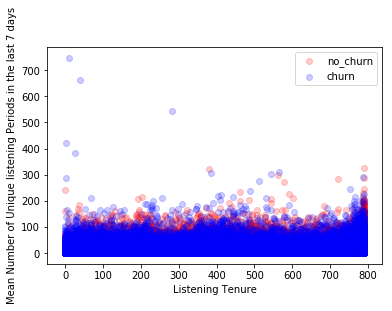

In [31]:
color = ['red', 'blue']
plt.figure()
for color, i, name in zip(color, [0,1], ['no_churn', 'churn']):
    plt.scatter(df_fa[df_fa['is_churn'] == i]['date_featuresdatelistening_tenure'],
               df_fa[df_fa['is_churn'] == i]['within_days_7num_unqmean'], color = color, alpha = 0.2, label = name)
plt.legend(loc = 'best')
plt.xlabel('Listening Tenure')
plt.ylabel('Mean Number of Unique listening Periods in the last 7 days')

Looking at the above plot, we can see that overall people who churn have low numbers of unique plays, meaning they aren't using the music service. We can also see a spike in number of unique plays for users who have a long tenure (>700 days). Intuitively this makes sense as users who are commited to the service (have used the service for a long time) may have developed lifestyle patterns where they use the service while driving/working/etc.

In [32]:
avg_price_no_churn = round(df_fa[df_fa['is_churn'] == 0]['amount_paid_per_day'].mean(), 2)
avg_price_is_churn = round(df_fa[df_fa['is_churn'] == 1]['amount_paid_per_day'].mean(), 2)
print('Avg cost/day for no churn: %.2f' %avg_price_no_churn)
print('Avg cost/day for churn: %.2f' %avg_price_is_churn)

Avg cost/day for no churn: 4.54
Avg cost/day for churn: 4.67


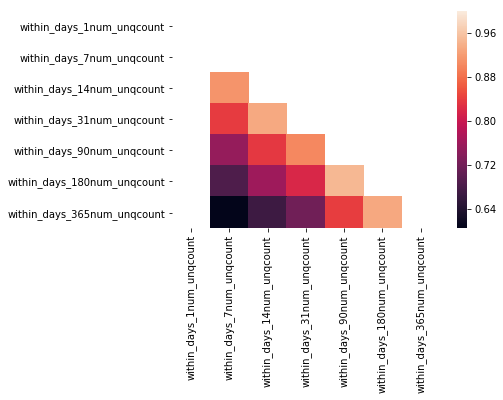

In [33]:
corr = df_fa.iloc[:, 8:99:15].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, mask=mask)

In [34]:
mean_col = df_fa.iloc[:, 7:98:15].mean()
mean_col

within_days_1num_unqmean      20.698794
within_days_7num_unqmean      21.900082
within_days_14num_unqmean     22.383794
within_days_31num_unqmean     23.271521
within_days_90num_unqmean     24.238664
within_days_180num_unqmean    24.740990
within_days_365num_unqmean    25.245055
dtype: float64

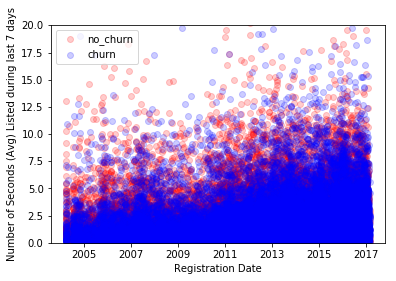

In [35]:
#plt.plot_date(reg_time, df_fa['within_days_7total_secsmean'], )
color = ['red', 'blue']
for color, i, name in zip(color, [0,1], ['no_churn', 'churn']):
    plt.plot_date(pd.to_datetime(df_fa[df_fa['is_churn'] == i]['registration_init_time'], format = '%Y%m%d'),
               df_fa[df_fa['is_churn'] == i]['within_days_7total_secsmean']/(60*60), color = color, alpha = 0.2, label = name)
plt.legend(loc = 'best')
plt.xlabel('Registration Date')
plt.ylim([0,20])
plt.ylabel('Number of Seconds (Avg) Listed during last 7 days')

This plot shows the Registration Date vs Avg seconds listened over past 7 days. The intent will be to change this to transaction date as this will more accurately reflect when the user ends service. We can see a trend in more churn occuring in the last 4 years of the dataset. This could be due to an increased level of users however (same proportion of churn).

<function matplotlib.pyplot.show>

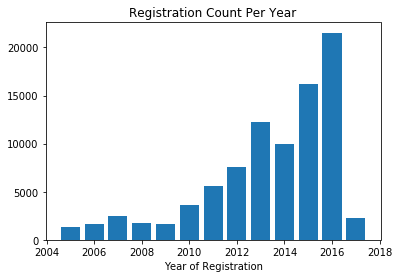

In [36]:
df_fa['registration_time'] = pd.to_datetime(df_fa['registration_init_time'], format = '%Y%m%d').map(lambda x: x.year)
reg_count = []
thirty_day_churn = []
for year in range(2005, 2018):
    reg_count.append(sum(df_fa['registration_time'] == year))
    thirty_day_churn.append(len(df_fa[(df_fa['registration_time'] == year) & (df_fa['date_featuresdatelistening_tenure'] < 30) & (df_fa['is_churn'] == 1)])/sum(df_fa['registration_time'] == year))
plt.bar(range(2005, 2018), reg_count)
plt.xlabel('Year of Registration')
plt.title('Registration Count Per Year')
plt.show

<function matplotlib.pyplot.show>

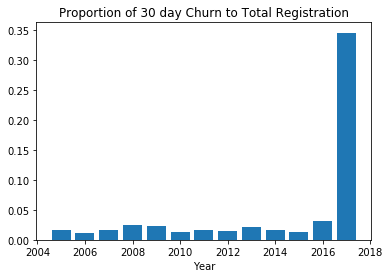

In [37]:
plt.bar(range(2005, 2018), thirty_day_churn)
plt.xlabel('Year')
plt.title('Proportion of 30 day Churn to Total Registration')
plt.show

This statistic shows that there is a high level of churn recently for users who are using a trial subscription, or who a very short duration subscription. From a business perspective this is concerning, because it means that a very high level of churn is occuring, and the problem needs to be solved to reduce churn levels back. The sharp spike may have been when the company started offering 30 days subscriptions or some other factor that has caused increased churn for customers with less than 30 day subscriptionps.

# 8. Writing Output

Having extracted our features and performing some data manipulation, we will now write the features file to a .pkl file, allowing us to use this output in the second notebook without having to run all the code above.

In [38]:
#Write all features to pkl
df_fa.to_pickle('df_fa.pkl')